<a href="https://colab.research.google.com/github/miapienkowski/cs254FinalProject/blob/Mia/imgSegmModelFin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


In [4]:
#import data from git repository
!git clone https://github.com/miapienkowski/cs254FinalProject.git

fatal: destination path 'cs254FinalProject' already exists and is not an empty directory.


In [24]:
#filterDataset processes data

#mode train or validating or testing
def filterDataset(folder, classes=None, mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/{}val.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [25]:
#image processeing
def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img

#normal mask : 2-channel semantic segmentation mask with dimensions equal to the original image    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
#binary mask: 2 pixel values- 1 (object: could be any of the N classes) and 0 (the background)   
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask

In [26]:
#builds generator type object
#performs batch-sized loops [lines 20~] and retrieves the image from the folder,
# loads the mask with the filtered outputs (binary or normal segmentation masks), 
# lumps them to form an image batch and mask batch

def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mode='train', mask_type='binary'):
    

    img_folder = '{}/data'.format(folder)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [63]:
def getImageMask(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mode='train', mask_type='binary'):
    

    img_folder = '{}/data'.format(folder)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 154
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        return img, mask

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [28]:
#get processed validating data
#validating
val_folder = 'cs254FinalProject/validatingDirectory'
val_classes = ['cable', 'tower_lattice', 'tower_tuchoy','tower_wooden']
val_mode = 'validating'

val_images, val_dataset_size, val_coco = filterDataset(val_folder, val_classes, val_mode)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [29]:
#get processed training data
#training
train_folder = 'cs254FinalProject/trainingDirectory'
train_classes = ['cable', 'tower_lattice', 'tower_tuchoy','tower_wooden']
train_mode = 'train'

train_images, train_dataset_size, train_coco = filterDataset(train_folder, train_classes, train_mode)

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


In [30]:
#get processed training data
#training
test_folder = 'cs254FinalProject/testingDirectory'
test_classes = ['cable', 'tower_lattice', 'tower_tuchoy','tower_wooden']
test_mode = 'test'

test_images, test_dataset_size, test_coco = filterDataset(test_folder, test_classes, test_mode)

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


In [31]:
#creates a data generator object yielding batches of images and binary mask
#val
batch_size = 4
input_image_size = (224,224)
mask_type = 'binary'

val_gen = dataGeneratorCoco(val_images, val_classes, val_coco, val_folder, 
                            input_image_size, batch_size, val_mode, mask_type)

In [32]:
#creates a data generator object yielding batches of images and binary mask
#train
batch_size = 4
input_image_size = (224,224)
mask_type = 'binary'

train_gen = dataGeneratorCoco(train_images, train_classes, train_coco, train_folder, 
                            input_image_size, batch_size, train_mode, mask_type)

In [43]:
#creates a data generator object yielding batches of images and binary mask
#test
batch_size = 4
input_image_size = (224,224)
mask_type = 'binary'

test_gen = dataGeneratorCoco(test_images, test_classes, test_coco, test_folder, 
                            input_image_size, batch_size, test_mode, mask_type)

In [64]:
batch_size = 4
input_image_size = (224,224)
mask_type = 'binary'

tIm, Tms = getImageMask(test_images, test_classes, test_coco, test_folder, 
                            input_image_size, batch_size, test_mode, mask_type)

In [34]:
n_epochs = 10
steps_per_epoch = train_dataset_size// batch_size
validation_steps = val_dataset_size // batch_size

In [35]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-hs0xpscm
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-hs0xpscm
  Created wheel for tensorflow-examples: filename=tensorflow_examples-a4febbbd69d2632e7ed28e5a58f8473d814431b3_-cp37-none-any.whl size=225469 sha256=66eaa6064b35e3e2c878b744e9f042b9e0364e557bd04a19ec0590f66a6b7e3e
  Stored in directory: /tmp/pip-ephem-wheel-cache-1vyyo14c/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [36]:
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow as tf

In [37]:
OUTPUT_CHANNELS = 3
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [38]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [39]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [40]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model_history = model.fit(x = train_gen,
                validation_data = val_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                epochs = n_epochs,
                verbose=True)

Epoch 1/10
226/226 [==============================] - 199s 865ms/step - loss: 0.1866 - accuracy: 0.9783 - val_loss: 0.1236 - val_accuracy: 0.9493
Epoch 2/10
226/226 [==============================] - 196s 867ms/step - loss: 0.1060 - accuracy: 0.9743 - val_loss: 0.0997 - val_accuracy: 0.9656
Epoch 3/10
226/226 [==============================] - 195s 864ms/step - loss: 0.0971 - accuracy: 0.9660 - val_loss: 0.0973 - val_accuracy: 0.9656
Epoch 4/10
226/226 [==============================] - 193s 853ms/step - loss: 0.0848 - accuracy: 0.9672 - val_loss: 0.1023 - val_accuracy: 0.9820
Epoch 5/10
226/226 [==============================] - 195s 864ms/step - loss: 0.0849 - accuracy: 0.9628 - val_loss: 0.1419 - val_accuracy: 0.9803
Epoch 6/10
226/226 [==============================] - 196s 869ms/step - loss: 0.0825 - accuracy: 0.9682 - val_loss: 0.0936 - val_accuracy: 0.9750
Epoch 7/10
226/226 [==============================] - 195s 865ms/step - loss: 0.0791 - accuracy: 0.9634 - val_loss: 0.0950 -

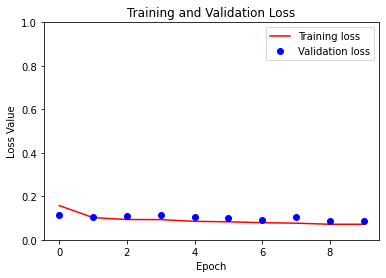

In [54]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(n_epochs)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:

predictions = model.predict(test_gen,3)

In [66]:
predictions = model.predict_generator(test_gen, 4)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
model.evaluate_generator(test_gen)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
